In [ ]:
import tcm
import matplotlib.pyplot as plt

In [81]:

fitname = "250513-jth-exa-nnlo-mtt-8tev-alphas_mt_tcm"
pred, P_tilde = tcm.compute_posterior(fitname)


In [82]:
fitname = "250513-jth-exa-nnlo-mtt-8tev-alphas_mt_tcm_iterated"
pred_iterated, P_tilde_iterated = tcm.compute_posterior(fitname)

In [85]:
def plot_ellipse(mu0, sigma, labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    hndls = []
    colors=["C0", "C1", "C2", "C3"]
    for i, (mu0_i, sigma_i) in enumerate(zip(mu0, sigma)):
        p1 = tcm.confidence_ellipse(
            sigma_i,
            mu0_i,
            ax=ax,
            alpha=1,
            edgecolor=colors[i],
            confidence_level=68,
        )
        
        p2 = tcm.confidence_ellipse(
            sigma_i,
            mu0_i,
            ax=ax,
            alpha=0.3,
            edgecolor=None,
            facecolor=colors[i],
            confidence_level=68,
        )
        
        ax.scatter(
            mu0_i[0], mu0_i[1],
            c='k',
            s=20,
            marker="+",
        )
        
        hndls.append((p1, p2))
        
        # msbar_to_pole = 10.38
        # pred_abmp = [160.6 + msbar_to_pole, 0.115]
        # cov_abmp = np.array([[0.6 ** 2, 0], [0, 0.0009 ** 2]])
        
        
    ax.tick_params(top=True, right=True, direction="in")
    plt.xlabel(r'$m_{t}\:{\rm [GeV]}$', fontsize=15)
    plt.ylabel(r'$\alpha_s$', fontsize=15)
    plt.title(r"$68\%\:\rm{C.L.\:interval}$", fontsize=15)
    plt.grid(True)
    
    mt_pdg = 172.4
    as_pdg = 0.118
    
    #ax.set_xlim(171.5, 173.0)
    #ax.set_ylim(pred[1] - 0.0015, pred[1] + 0.0015)
    
    ax.legend(
        labels=labels,
        handles=hndls,
        loc="upper left",
        frameon=False,
        fontsize=15,
        handlelength=1,
        borderpad=0.5,
        handletextpad=1,
        title_fontsize=24,
    )
    plt.savefig("plots/tcm_post_mtt_test.pdf")
    plt.show()



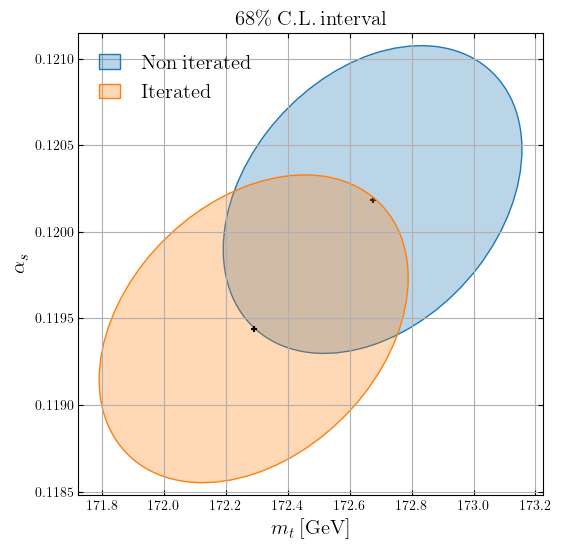

In [86]:
plot_ellipse(
    mu0=[pred, pred_iterated],
    sigma=[P_tilde, P_tilde_iterated],labels=[r"$\mathrm{Non\:iterated}$", r"$\mathrm{Iterated}$"])